In [106]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
# !pip install plotly plotly
import plotly.graph_objects as go

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Open data

In [9]:
!pip show plotly
!pip show scikit-image

Name: plotly
Version: 5.16.1
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: c:\users\labib\anaconda3\lib\site-packages
Requires: tenacity, packaging
Required-by: 
Name: scikit-image
Version: 0.18.1
Summary: Image processing in Python
Home-page: https://scikit-image.org
Author: None
Author-email: None
License: Modified BSD
Location: c:\users\labib\anaconda3\lib\site-packages
Requires: numpy, scipy, matplotlib, networkx, pillow, imageio, tifffile, PyWavelets
Required-by: 


In [107]:
from PIL import Image
from matplotlib import image

##NPY File
# filepath = r'../Data/CT_scan.npy'
filepathA = r'C:/Users/labib\Documents/code/ImageSegmentation/Data/ID_0076ae919.npy'
# filepath = r'C:/Users/labib\Documents/code/ImageSegmentation/Data/chestmnist.npz'
npy = np.load(filepathA)
# plt.show(npy)
npy.shape
# plt.pcolormesh(npy)




(512, 512, 3)

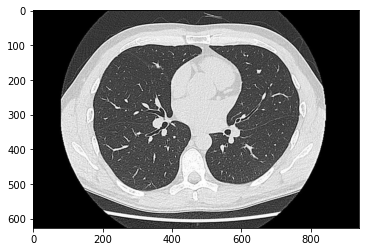

In [108]:
##Image File
filepath = r'C:/Users/labib\Documents/code/ImageSegmentation/Data/valid/normal/7.png'
img = image.imread(filepath)
# img.shape
plt.imshow(img)
# plt.show()

In [109]:
img.shape

(627, 940, 3)

Plot slice of the image:

ValueError: too many values to unpack (expected 2)

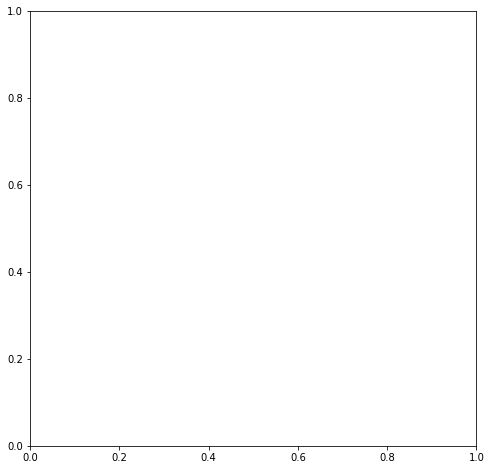

In [115]:
plt.figure(figsize=(8,8))
plt.pcolormesh(img], cmap='Greys_r')
plt.colorbar()

What do these units mean? The pixel values of this CT scan are expressed in Hounsfield Units

$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

where $\mu$ is the linear attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_0e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies $\approx 100$keV. Here are typical HU values:

<p align="center">
  <img src="../images/HU.PNG" alt="drawing" width="600" align="center"/>
</p>

# Modify data

The first thing to note is that air is signifcantly less HU than other substances in the body, so we apply a so-called "threshhold" mask. Lets use -320 HU as the lower limit:

In [5]:
mask = img < -320

Plot the mask

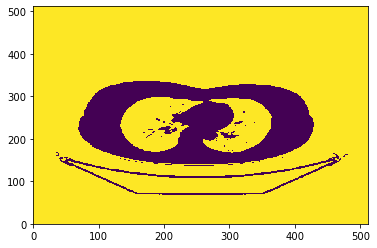

In [6]:
plt.pcolormesh(mask[170])

Next we can use the `clear_border` function to remove the outer border:

In [7]:
mask.shape

(263, 512, 512)

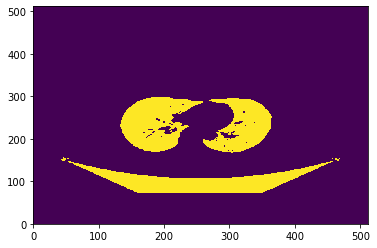

In [8]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask[170])

Now we'll give each seperate volume a different integer value using the `label` function

In [9]:
mask.shape

(263, 512, 512)

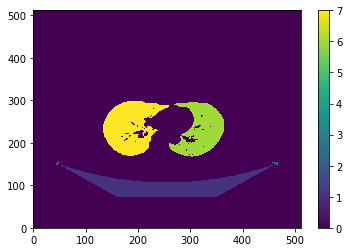

In [10]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[170])
plt.colorbar()

Now for something a little non-intuitive. We want to keep the three largest areas for each slice of the image. Why would we want to do this if we only want to keep the two lungs?

* In some slices one of the lungs could be larger than the table
* In some slices one of the lungs could be smaller than the table

If we only take the largest two slices, we might end up taking the table and one of the lungs. So for now lets take the top 3. The function below is designed to operate on a single slice of the 3D image:

In [11]:
slc = mask_labeled[170]

In [12]:
rps = regionprops(slc)

In [13]:
areas = [r.area for r in rps]

In [14]:
areas

[11529, 34, 35, 2, 5, 7745, 9900]

In [15]:
np.argsort(areas)[::-1]

array([0, 6, 5, 2, 1, 4, 3], dtype=int64)

In [16]:
slc = mask_labeled[170]
rps = regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1] # we want largest to smallest

Only consider the 3 largest areas (iterating theough `idxs`). Add these areas to a new slice called `new_slc`:

In [17]:
new_slc = np.zeros_like(slc)

In [18]:
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1

Plot 

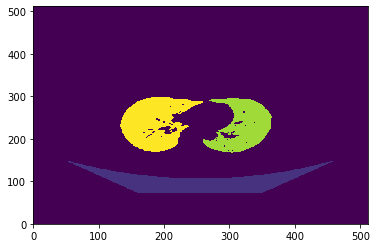

In [19]:
plt.pcolormesh(new_slc)

Now lets automate this for all slices in our 3D image:

In [20]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [21]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)

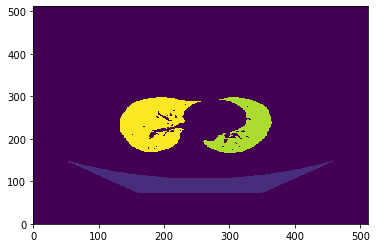

In [22]:
plt.pcolormesh(mask_labeled[165])

Now lets fill in any small holes in the lungs:

In [23]:
mask = mask_labeled > 0

In [24]:
mask.shape

(263, 512, 512)

In [25]:
mask.shape

(263, 512, 512)

In [26]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

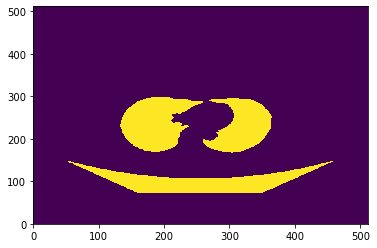

In [27]:
plt.pcolormesh(mask[170])

In some slices, the trachea is kind of annoying and we need to remove it:

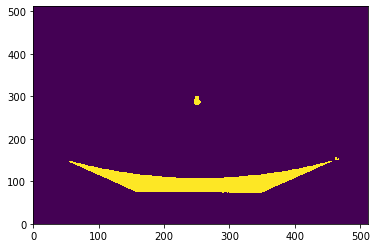

In [28]:
plt.pcolormesh(mask[-50])

In a 512x512 image, the trachea typically takes up less than 0.69% of the area. We can delete all regions that have any area smaller than this percentage:

In [29]:
mask[-50]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
labels = label(mask[-50],connectivity=1,background=0)

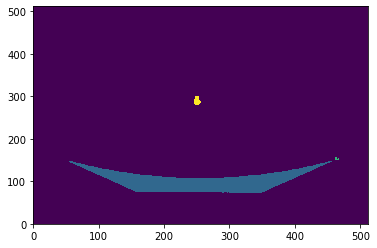

In [31]:
plt.pcolormesh(labels)

In [32]:
rps = regionprops(labels)

In [33]:
rps

In [34]:
areas = np.array([r.area for r in rps])

In [35]:
areas

array([11534,    33,   170])

In [36]:
np.where(areas/512**2 < 0.0069)

(array([1, 2], dtype=int64),)

In [37]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [38]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

Now the trachea is removed in the slice we were considering:

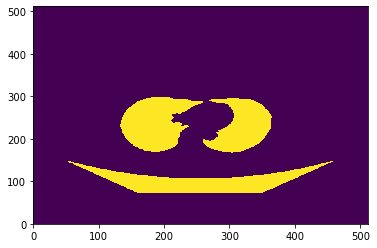

In [39]:
plt.pcolormesh(mask[170])

Finally, its time to remove the table. Note that the center of mass of the table is always lower than the two lungs. As such, we simply need to delete the volume with the lowest center of mass in $y$ to delete the table:

In [40]:
labels = label(mask[170], background=0)

Plot a slice of the labels with the masks:

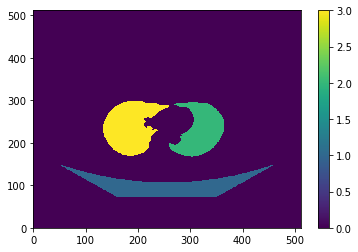

In [41]:
plt.pcolormesh(labels)
plt.colorbar()

Compute the center of masses in this slice:

In [42]:
center_of_mass(labels==3)[0]

237.06954832442935

In [43]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [44]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

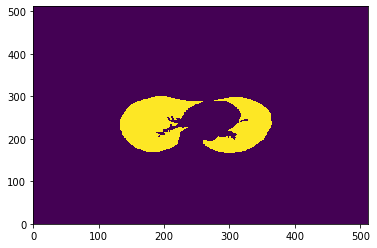

In [45]:
plt.pcolormesh(mask_new[167])

Finally, we can expand the area of the lungs a little bit by growing the border. For this, we can use the `binary_dilation` function:

In [46]:
mask_new = binary_dilation(mask_new, iterations=5)

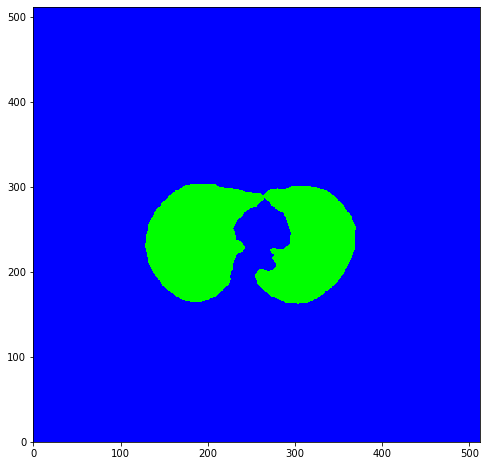

In [47]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new[170], cmap='brg')

Lets plot the full 3D image in plotly and create an interactive plot:

* First decrease the resolution a little bit:

In [48]:
im = zoom(1*(mask_new), (0.4,0.4,0.4))

Get arrays of $x$, $y$, and $z$. In a CT scan, the difference between pixels in the z direction is about 4 times bigger than in the $x$ and $y$ directions:

In [49]:
z, y, x = [np.arange(i) for i in im.shape]
z*=4

Create a meshgrid:

In [50]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

Create a 3D plotly plot

In [51]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test.html")

In [52]:
img_new = mask_new * img

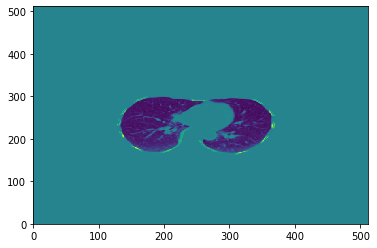

In [53]:
plt.pcolormesh(img_new[170])